In [ ]:
# --------------- Collect Raw data --------------- #
import yfinance as yf
from datetime import datetime, timedelta

# Parameters
ticker = "SPY"
end_date = datetime.today()
start_date = end_date - timedelta(days=6 * 365)

# Download 6 years of daily data
data = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))

# Keep only OHLCV
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.reset_index(inplace=True)  # Make Date a column

# Ensure it's sorted
data.sort_values("Date", inplace=True)

# Split into train (first 5 years) and test (last year)
split_date = data["Date"].iloc[-252]  # ~252 trading days per year

train_df = data[data["Date"] < split_date]
test_df = data[data["Date"] >= split_date]

# Save to CSV
train_df.to_csv("raw/train.csv", index=False)
test_df.to_csv("raw/test.csv", index=False)

print(f"Downloaded {len(data)} total rows")
print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

In [8]:
# -------- Step 1: load raw data and reformat for generating features -------- #
def convert_for_singleexe(input_csv, output_txt):
    df = pd.read_csv(input_csv)

    # Format the Date column as YYYYMMDD integers
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y%m%d').astype(int)

    # Keep only required columns in correct order
    df_out = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

    # Save as space-separated file with no header
    df_out.to_csv(output_txt, sep=' ', index=False, header=False)
    print(f"Saved: {output_txt}")

# Convert both train and test
convert_for_singleexe("raw/train.csv", "preprocessed/market_train.txt")
convert_for_singleexe("raw/test.csv", "preprocessed/market_test.txt")

Saved: market_train.txt
Saved: market_test.txt


In [4]:
# -------- Step 2: Run Single.exe to generate features -------- #
# Rename them into output_train.TXT and output_test.TXT

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/Projects/APS1052/SINGLE.exe'

In [209]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# -------- Step 3: compute directional target with noise filtering -------- #
train_raw = pd.read_csv("raw/train.csv")
test_raw = pd.read_csv("raw/test.csv")

features_train = pd.read_csv("generated/output_train.TXT", sep=r"\s+")
features_test = pd.read_csv("generated/output_test.TXT", sep=r"\s+")

# Format Date
train_raw['Date'] = pd.to_datetime(train_raw['Date'])
test_raw['Date'] = pd.to_datetime(test_raw['Date'])

# Compute 1-day forward raw return
train_raw['return'] = train_raw['Close'].shift(-1) / train_raw['Close'] - 1
test_raw['return'] = test_raw['Close'].shift(-1) / test_raw['Close'] - 1

# Apply noise filter: ignore tiny movements
threshold = 0.003  # 0.3%
train_raw['target'] = np.where(train_raw['return'] > threshold, 1,
                        np.where(train_raw['return'] < -threshold, 0, np.nan))

test_raw['target'] = np.where(test_raw['return'] > threshold, 1,
                       np.where(test_raw['return'] < -threshold, 0, np.nan))

# Convert date back to match feature files
train_raw['Date'] = train_raw['Date'].dt.strftime('%Y%m%d').astype(int)
test_raw['Date'] = test_raw['Date'].dt.strftime('%Y%m%d').astype(int)

# Drop rows with NaN target (neutral/no-signal samples)
train_raw.dropna(subset=['target'], inplace=True)
test_raw.dropna(subset=['target'], inplace=True)

# Ensure target is integer type
train_raw['target'] = train_raw['target'].astype(int)
test_raw['target'] = test_raw['target'].astype(int)

# -------- Step 4: Merge features with filtered targets -------- #
train_merged = pd.merge(features_train, train_raw[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'target']], on='Date', how='inner')
test_merged = pd.merge(features_test, test_raw[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'target']], on='Date', how='inner')

# Select feature candidates
all_features = [col for col in train_merged.columns if col not in ['Date', 'target']]

X_train = train_merged[all_features]
y_train = train_merged['target']

# Feature selection
num_feature_select = 12
selector = SelectKBest(score_func=mutual_info_classif, k=num_feature_select)
selector.fit(X_train, y_train)

top_features = X_train.columns[selector.get_support()].tolist()
print(f"Top {num_feature_select} features: {top_features}")


# Apply to test set
X_test = test_merged[top_features]
y_test = test_merged['target']

# Save to CSV
train_final = pd.concat([train_merged[['Date']], X_train[top_features], y_train], axis=1)
test_final = pd.concat([test_merged[['Date']], X_test, y_test], axis=1)

train_final.to_csv("final/train_final.csv", index=False)
test_final.to_csv("final/test_final.csv", index=False)

print("✅ Saved filtered train/test sets with threshold binary target (±0.3%)")

Top 12 features: ['RSI7', 'MACD', 'STOCH14', 'QUADTREND10', 'AROONDOWN14', 'QUAD_DEV', 'PRICE_OSC', 'MONEYFLOW', 'High', 'Low', 'Close', 'Volume']
✅ Saved filtered train/test sets with threshold binary target (±0.3%)


In [210]:
# -------- Step 5: Train XGBoost Classifier -------- #
train_df = pd.read_csv("final/train_final.csv")
test_df = pd.read_csv("final/test_final.csv")

X_train = train_df.drop(columns=["Date", "target"])
y_train = train_df["target"]

X_test = test_df.drop(columns=["Date", "target"])
y_test = test_df["target"]

In [256]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# -------- Step 5: Train Classifier -------- #
model_1 = XGBClassifier(
    n_estimators=5500,
    learning_rate=0.0001,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    eval_metric='logloss',
    random_state=42
)
model_1.fit(X_train, y_train)

# -------- Step 6: Evaluate Model -------- #
y_pred = model_1.predict(X_test)
y_prob = model_1.predict_proba(X_test)[:, 1]  # Probability for class 1

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.580952380952381


<Figure size 1000x600 with 0 Axes>

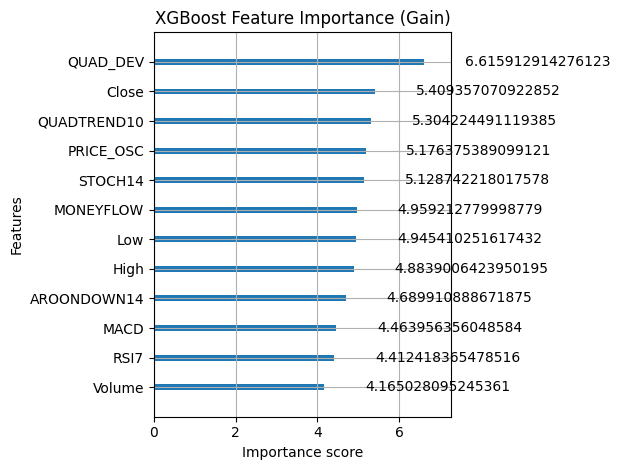

In [212]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot top 12 important features based on gain
plt.figure(figsize=(10, 6))
plot_importance(model_1, max_num_features=12, importance_type='gain', title='XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()

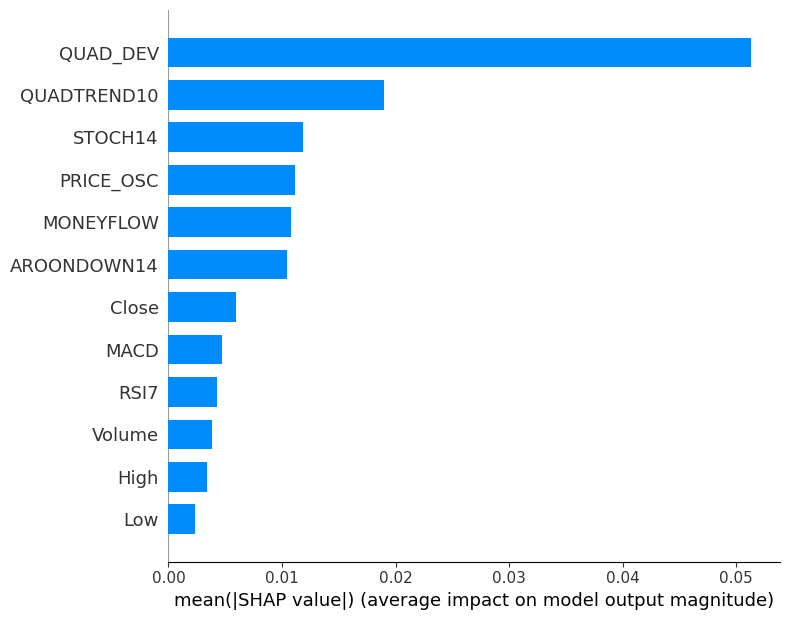

In [213]:
import shap

# Create TreeExplainer for your model
explainer = shap.TreeExplainer(model_1)
shap_values = explainer.shap_values(X_test)

# Summary plot (bar chart for overall importance)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [257]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# -------- Model 2: Random Forest -------- #
model_2 = RandomForestClassifier(
    n_estimators=3000,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)
model_2.fit(X_train, y_train)

# -------- Evaluate Model 2 -------- #
y_pred_rf = model_2.predict(X_test)
y_prob_rf = model_2.predict_proba(X_test)[:, 1]

# Metrics
acc_rf = accuracy_score(y_test, y_pred_rf)

print("Accuracy:", acc_rf)

Accuracy: 0.5523809523809524


In [258]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 256, 64),
    activation='relu',
    solver='adam',      
    learning_rate_init=0.0005,   
    max_iter=2000,
    random_state=42
)
model_mlp.fit(X_train_scaled, y_train)

# -------- Evaluate Model MLP -------- #
y_pred_mlp = model_mlp.predict(X_test_scaled)

# Metrics
acc_mlp = accuracy_score(y_test, y_pred_mlp)

print("Accuracy:", acc_mlp)

Accuracy: 0.580952380952381
